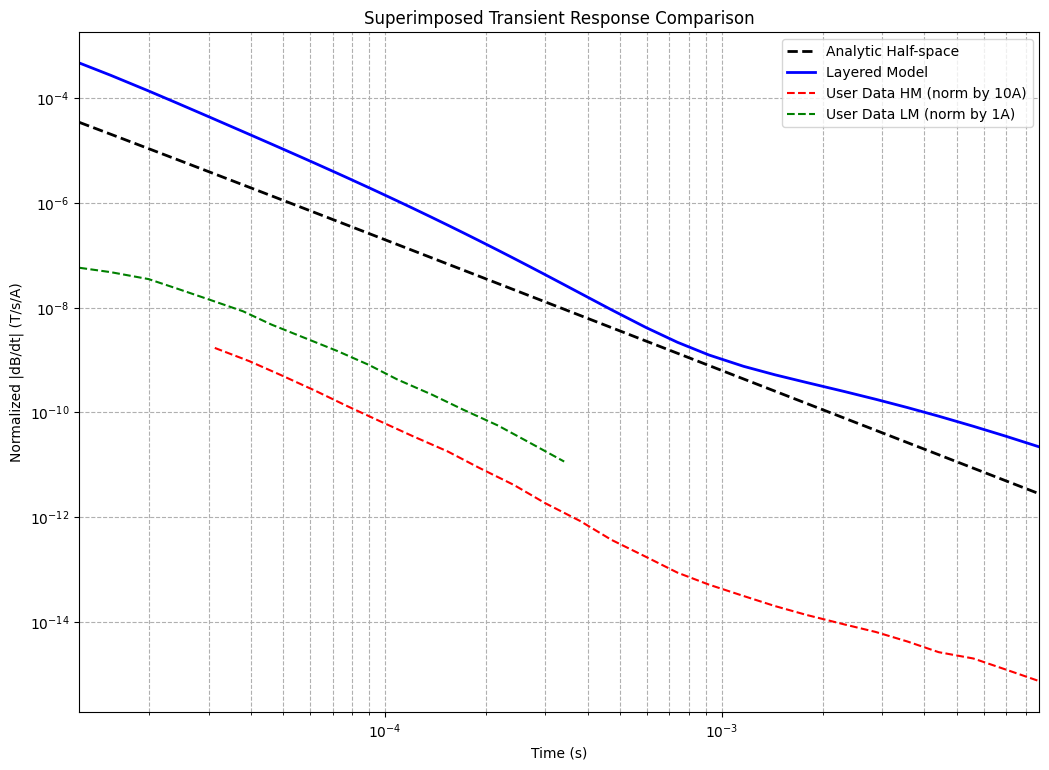

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from discretize import CylindricalMesh

data_hm = pd.read_csv('Dataset_S_HM.csv')
time_hm = data_hm['Time'].values
dbdt_hm = data_hm['dB/dt'].values
data_lm = pd.read_csv('Dataset_S_LM.csv')
time_lm = data_lm['Time'].values
dbdt_lm = data_lm['dB/dt'].values

dbdt_hm_normalized = dbdt_hm / 10.0
dbdt_lm_normalized = dbdt_lm / 1.0

time_channels = np.unique(np.sort(np.concatenate((time_lm, time_hm))))

rho = np.array([
    10.4, 50.1, 61.3, 33.4, 27.0, 104, 303, 571, 778, 841, 751,
    545, 296, 105, 20.6, 5.11, 11.6, 16.0, 16.8, 17.6
])
thk = np.array([
    6.06, 6.84, 7.72, 8.72, 9.85, 11.1, 12.6, 14, 16, 18.1,
    21, 23, 26, 29.3, 33.1, 37.4, 42.1, 47.7, 53.8
])

sigma_layered = 1.0 / rho

source_location = np.array([0.0, 0.0, 0.1])
source_orientation = "z"
source_current = 1.0
source_radius = 20.0
receiver_locations = np.array([0.0, 0.0, 0.0])
receiver_orientation = "z"
halfspace_conductivity = 1e-2

def generate_survey(waveform_object):
    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_locations, time_channels, orientation=receiver_orientation
        )
    ]
    source_list = [
        tdem.sources.CircularLoop(
            receiver_list=receiver_list,
            location=source_location,
            waveform=waveform_object,
            current=source_current,
            radius=source_radius,
        )
    ]
    return tdem.Survey(source_list)

stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

sim_halfspace = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(stepoff_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1),
)
dpred_halfspace = sim_halfspace.dpred(np.array([halfspace_conductivity]))

sim_layered = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(stepoff_waveform),
    thicknesses=thk,
    sigmaMap=maps.IdentityMap(nP=len(sigma_layered)),
)
dpred_layered = sim_layered.dpred(sigma_layered)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])

ax1.loglog(time_channels, -dpred_halfspace, "k--", lw=2, label="Analytic Half-space")
ax1.loglog(time_channels, -dpred_layered, "b-", lw=2, label="Layered Model")
ax1.loglog(time_hm, dbdt_hm_normalized, "r--", markersize=5, label="User Data HM (norm by 10A)")
ax1.loglog(time_lm, dbdt_lm_normalized, "g--", markersize=6, label="User Data LM (norm by 1A)")

ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid(True, which="both", ls="--")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Normalized |dB/dt| (T/s/A)")
ax1.set_title("Superimposed Transient Response Comparison")
ax1.legend()
plt.show()
